# Description

This Jupyter notebook example demonstrates how to run buckling analysis on a model of the EMULF Delta Floater, exposed to time-dependent wave loads coming from Sima coupled analysis results via direct load generation in Wasim, using OneWorkflow locally.

Note that this is an updated version (v2) of the EMULF DeltaFloater Sesam ULS example. This version runs the calm sea condition only once and is therefore more efficient. The stiffeners have eccentricity.

Highlighted features of this example:
- Read control data from Excel spreadsheet into a dictionary (Python), including file names for coupled analysis result, as well as start and stop times for Wasim direct load generation and load transfer. More control data can easily be added to the spreadsheet and transferred to relevant input files using [`CreateInputFileFromFileTemplateCommand` (OneWorkflow)](https://myworkspace.dnv.com/download/public/sesam/workflow/docs/latest/source/dnv.oneworkflow.html#dnv.oneworkflow.create_input_file_from_file_template_command.CreateInputFileFromFileTemplateCommand). Some template control data are hardcoded by user in the notebook.
- Wasim non-linear is run, followed by a Sestra quasi-static analysis.
- Apply safety load factors. Load factors are first read from the spreadsheet, then modified and applied to the loads resulting from two Wasim runs, where one (total) loadcase includes all load effects and one (calm sea) load case includes only permanent loads. A single Sestra analysis is then run using the scaled and combined loads. The modified factors are applied to separate L#-files and then combined in sestra.inp using the MULL card. Note that the calm sea run is run locally, whilst all other load cases (DLCs) are run using a worker (OneWorkflow).
- One row set up for short time period direct load generation and/or short time period load transfer only. Repeat rows for multiple events and/or seeds.
- (A threshold value limiting output of usage factor results can be applied directly on the command line in the Sesam Core task. See options in [`SesamCoreCommand`](https://myworkspace.dnv.com/download/public/sesam/workflow/docs/latest/source/dnv.sesam.commands.html#dnv.sesam.commands.sesam_core_command.SesamCoreCommand).)
- Control Sesam Core run using commands in journal (JNL) file.
- Graphs of reaction force in z-direction from Sestra are presented for each DLC. PNG files are automatically saved for each DLC.
- Buckling results are presented as a table of worst usage factor over all time steps and DLCs for each stiffened plate field. The number of worst stiffeners/lines/graphs is controlled by the user. Minor detail: Note that the table also can skip a number of first the time steps, to avoid unrealistic result peaks (if present).
- Buckling results are also shown for a user selected number of graphs starting from a user selected usage factor as time-history plots of usage factor of all stiffeners in each stiffened plate field. 
- Separate start and stop of buckling calculation in Sesam Core command journal file based on Excel input. Sestra is here run for all time steps with load mapping.

The capacity model comes as a single JSON file from GeniE, and results are currently stored in one .csv and one .lis file for each stiffened plate field. Two different capacity models are provided where one is the main column with pontoon and brace and the second is the full substructure model (see middle picture below).


![EMULF Deltafloater](EMULF_pict.png)


# OneWorkflow setup

- Specify <font color='red'>root_folder / workspaceId</font>.
- Local workflow runtime temp folder path is the default: <font color='red'>C:\Temp\OneWorkflow</font>.
- Specify Excel file with load case names, start/stop/time step info and safety load factors for the input_data variable (<font color='red'>control_input2.xlsx</font>).
- (Use <font color='red'>cloudRun</font> variable to control running locally or in the cloud. (**note**: Let this be `False` until cloud support has been added and you have a valid cloud subscription.))

In [1]:
from pathlib import Path
import os, sys
import pandas as pd
sys.path.append("../PythonModules")
root_folder = os.getcwd()

#User defined setup, see comments above
workspacePath = str(Path(root_folder, 'Workspace'))
workspaceId = "EMULF_DeltaFloater_Sesam_ULS"
cloudRun = False
input_data = pd.read_excel(os.path.join(workspacePath, "control_input2.xlsx"), index_col=1)
print("Root folder is ", root_folder)


Root folder is  c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2


# Read Excel input, update template parameters in .inp files, run Wasim and Sesam Core

Files and file locations:
- Sima coupled analysis results files in the *LoadCases\\<load_case_name_from_excel>\\* folder. Results for a separate calm sea load case is required to calculate load factors.
- All other model and input, including template files are found in the *CommonFiles* folder

In [2]:
#remove existing results before running the analysis
import shutil
clean = True
if clean:
    shutil.rmtree(os.path.join(workspacePath,"LoadCases"), ignore_errors=True)
shutil.copytree(os.path.join(workspacePath,"Input"),os.path.join(workspacePath),dirs_exist_ok=True)


#copy files from common files to CalmSea folder
common_files_folder = os.path.join(workspacePath,"CommonFiles")
calm_sea_dir = os.path.join(workspacePath, "LoadCases","_CalmSea")
for filename in os.listdir(common_files_folder):
    if filename.endswith(("S1.FEM", "L1.FEM", ".json", ".json.log", ".gnx", ".jnl")):
        continue  # Skip files ending with what is specified
    source_file = os.path.join(common_files_folder, filename)
    destination_file = os.path.join(calm_sea_dir, filename)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(source_file):
        shutil.copy2(source_file, destination_file)

In [3]:
#import pandas as pd
import os
from dnv.sesam.commands import *
from dnv.oneworkflow import *
import shutil
from WasimTaskCreator import *
import json

from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

# Template parameters hardcoded by user
topsuper = 1 #top superelement number
prefix_stru = "STR_" #prefix for structure files
fixed_parameters_all_load_cases = {
    'mor_topsel':  f"{topsuper}",
    'prefix': f"{prefix_stru}        ", #prefix, left-justified
    'prefix_stru': f"{prefix_stru}", #prefix, right-justified
    'prefix_struCalmSea': f'{prefix_stru}CalmSea',
    'prefix_struTotal' : f'{prefix_stru}Total'
} 


try:
    os.chdir(os.path.join(workspacePath,"LoadCases"))
except:
    print("LoadCases folder not found")
workflow_sequence = []


#Recognize the following column titles in Excel spreadsheet and map them to the correct input parameters given in Wasim template files
parameter_mapping = {'Group': "group",
				'LoadCase': "loadcase",
				"SimaFilesFolder": "sima_files_folder",
				"SimaFilesName": "sima_files_name",
                "TimeStep": "timestep",
				"Depth": "depth",
				"StartWasimSolve": "start_solve",
				"StopWasimSolve": "stop_solve",
            	"StartWasimStru": "start_stru",
				"StopWasimStru": "stop_stru",
				"NSteps": "nsteps",
				"StartSestra": "start_sestra",
				"StopSestra": "stop_sestra",
				"StartBuckling": "BUCKLINGSTART",
				"StopBuckling": "BUCKLINGEND",
				"LoadFactorSet": "loadfactorset",
                "fac_G": "fac_g",
                "fac_E": "fac_e",
                }

#Display data read from Excel
display(input_data)

#Loop over all load cases



12:52:47 27/06/2025


,Group,SimaFilesFolder,SimaFilesName,TimeStep,Depth,StartWasimSolve,StopWasimSolve,StartWasimStru,StopWasimStru,NSteps,StartSestra,StopSestra,StartBuckling,StopBuckling,LoadFactorSet,fac_G,fac_E
LoadCase,,,,,,,,,,,,,,,,,
_CalmSea,DLC_test,_Input,sima,0.1,NaN,0,800,200,800,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00
Sima_ULS_Hs11_Vw23,DLC_test_1,Sima_ULS_Hs11_Vw24,sima,0.1,NaN,320,400,330,380,500.0,NaN,NaN,340.0,380.0,ULS(a),1.25,0.70
Sima_ULS_Hs11_Deg90_Vw23,DLC_test_2,Sima_ULS_Hs11_Deg90_Vw24,sima,0.1,NaN,440,520,450,500,500.0,NaN,NaN,460.0,500.0,ULS(b),1.00,1.55


In [4]:
def get_parameters_for_load_case(case : dict, casename : str):
    
    input_parameters = {}
    for key, value in case.items():
        input_parameters[parameter_mapping[key]] = str(value)
    
    #Calculate modified load factors since Wasim results don't separate static and dynamic loads
    #CalmSea (named calm)  = static
    #Total (named fac_tot) = static + dynamic
    input_parameters["fac_tot"] = str(float(input_parameters['fac_e']))
    input_parameters["fac_calm"] = str(float(input_parameters['fac_g']) - float(input_parameters['fac_e']))
    input_parameters = input_parameters | fixed_parameters_all_load_cases
    
    return input_parameters

### Calm sea load case

Comments:
- The calm sea load case runs Wasim to create load files with the static/permanent loads.
- The calm sea template files are slightly different to the other template files in that Wasim solve runs fixed mode and that results for only two time steps are stored.
- The calm sea load case is always run locally (no temporary job or blob folders).
- After Wasim has completed the S#.FEM and L#.FEM files are copied to CommonFiles. Those file are later copied to all DLC folders when running. The SCAL factor in S#.FEM is updated in each DLC after copying to reflect the relevant DLC (factors in the spreadsheet).

In [5]:
from dnv.sesam.commands.executors import execute_command
import subprocess
from dnv.oneworkflow import CreateInputFileFromFileTemplateCommand, CommandInfo, PythonCommand
from dnv.sesam.commands import SestraCommand
calm_sea_tasks = []
workflow_sequence = []
casename = "_CalmSea"
calmSeaFolder = os.path.join(workspacePath,"LoadCases",casename)
for casename, case in input_data.iterrows():
   

    #===============================
    #===Use different wasim template files for calm sea run, defined on 1st line in spreadsheet and named _CalmSea.
    if casename != "_CalmSea":
         break
    
    os.chdir(calmSeaFolder)
    input_parameters = get_parameters_for_load_case(case.to_dict(), casename)
    #print("The following parameters are used for load case: " + casename)
    #print(json.dumps(input_parameters, indent=4, sort_keys=False))
    calm_sea_commands =  WasimTaskCreator().CreateTasks(input_parameters, "CalmSea")    
    print("Running Wasim including load transfer")
    for wasim_cmd in calm_sea_commands:
            print("running " + str(type(wasim_cmd)))
            execute_command(wasim_cmd)
    #Apply load factor
    fac_calm=input_parameters["fac_calm"]
    #print(f"running command python appendScalingFactor.py {prefix_stru}CalmSeaS1.FEM {fac_calm}")
    result = subprocess.run(["python", "appendScalingFactor.py", f"{prefix_stru}CalmSeaS1.FEM", f"{fac_calm}"],
                    capture_output=True,
                    text=True
                    )
    print(result.stdout)

    filesToCopy = [f"{prefix_stru}CalmSeaL1.FEM",f"{prefix_stru}CalmSeaS1.FEM"]
    commonFilesFolder = os.path.join(workspacePath,"CommonFiles")

    for file in filesToCopy:
        newFilePath = commonFilesFolder + os.path.sep + file
        print("file copied to " + newFilePath)
        shutil.copy(file, newFilePath)
    os.chdir(os.path.join(workspacePath,"LoadCases"))

INFO: The .NET Runtime Path 'C:\Users\hakber\AppData\Roaming\Python\Python312\site-packages\dnv\net\runtime\.net'
INFO: The .NET Runtime Version '.NET 8.0.4'. Runtime Identifier 'win-x64'.

Running Wasim including load transfer
running <class 'dnv.sesam.commands.wasim_command.WasimSetupCommand'>
running <class 'dnv.sesam.commands.wasim_command.WasimSolveCommand'>
running <class 'dnv.sesam.commands.wasim_command.WasimSnapShotsCommand'>
running <class 'dnv.sesam.commands.wasim_command.WasimStruCommand'>
running appendscalingfactor.py in folder c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\_CalmSea
Scaling factor 1.0 processed in STR_CalmSeaS1.FEM successfully.

file copied to c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\CommonFiles\STR_CalmSeaL1.FEM
file copied to c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-ge

## Start workflow worker running analysis in parallel

In [6]:
from dnv.oneworkflow.utils import *

from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

# local workspace, all results will be put here in the folder Loadcases, after local or cloud runs
# location of common files for all analysis, has to be below workspacePath and in the folder names CommonFiles
# If running locally the code below will also start the local workflow host.
workflow_client = one_workflow_client(workspace_id = workspaceId, cloud_run = cloudRun, workspace_path = workspacePath, inplace_execution=False, max_cores = 2)
workflow_sequence = []
for casename, case in input_data.iterrows():
   

    #===============================
    #===Use different wasim template files for calm sea run, defined on 1st line in spreadsheet.
    if casename != "_CalmSea":
        input_parameters = get_parameters_for_load_case(case.to_dict(), casename)
   
        #Continue with normal template files for all normal (total) runs.
        #===============================

        #Run Wasim including update of .inp files, for ULS including load factors
        tasks = WasimTaskCreator().CreateTasks(input_parameters)
        
        #Apply load factors
        fac_calm=input_parameters["fac_calm"]
        fac_tot = input_parameters["fac_tot"]
        #Need to update scaling factor for calm sea according to current DLC
        print(casename, "fac_calm =", fac_calm, "fac_tot =", fac_tot)
        # Update CalmSeaS#-file created by Wasim_stru, edit LCOM and append SCAL card
        scaling_command_calm = PythonCommand(
                directory=workflow_client.common_directory,
                filename="appendScalingFactor.py",
                args=f"{prefix_stru}CalmSeaS1.FEM {fac_calm}"
                )
        tasks.append(scaling_command_calm)

        # Update TotalS#-file created by Wasim_stru, edit LCOM and append SCAL card
        scaling_command_dyn = PythonCommand(
                directory=workflow_client.common_directory,
                filename="appendScalingFactor.py",
                args=f"{prefix_stru}TotalS1.FEM {fac_tot}"
                )
        tasks.append(scaling_command_dyn)

        #Update Sestra .inp file
        sestra_template_command = CreateInputFileFromFileTemplateCommand(
            template_input_file  = "sestra_template.inp",
            input_filename  = "sestra.inp",
            parameters= input_parameters
        )
        tasks.append(sestra_template_command)    
        
        #Update Sesam Core .jnl file
        sesam_core_template_command = CreateInputFileFromFileTemplateCommand(
            template_input_file  = "SesamCore_buckling_template.jnl",
            input_filename  = "SesamCore_buckling.jnl",
            parameters= input_parameters
        )
        tasks.append(sesam_core_template_command)
        
        #Run Sesam Core
        tasks.append(SesamCoreCommand(command = "ULS",input_file_name= "input.json", options = "-v"))
        
        #Run the above defined sequence of tasks
        workflow_sequence.append(CommandInfo(commands=tasks,load_case_foldername=casename))
    
    
print("Running commands in parallel")
await run_managed_commands_in_parallel_async(
            client=workflow_client,
            commands_info=workflow_sequence,
            log_job=False,
            files_to_exclude_from_common_files_copy= [f"{prefix_stru}CalmSeaT1.FEM", f"{prefix_stru}TotalT1.FEM"],
            files_to_download_from_blob_to_client=FileTransferOptions(max_size="11124MB",patterns=["**/*sestra.inp", "**/wasim_setup.inp", "**/wasim_solve.inp", 
                                                                                                    "**/wasim_snapshots.inp", "**/wasim_stru.inp", "**/*.csv", 
                                                                                                    "**/*.lis", "**/*.lis.bak", "**/*.mlg", "**/*.sin", "**/*.FEM", "**/*.jnl"]),
            enable_common_files_copy_to_load_cases=True,
)

13:02:35 27/06/2025
The temporary blob storage directory is: C:\Temp\OneWorkflow\oc_qrbodibt_blob
The temporary jobs root directory is: C:\Temp\OneWorkflow\oc_ps3r4hbi_jobs
Sima_ULS_Hs11_Vw23 fac_calm = 0.55 fac_tot = 0.7
Sima_ULS_Hs11_Deg90_Vw23 fac_calm = -0.55 fac_tot = 1.55
Running commands in parallel
Info: Attempt 1/10.LocalWorkflowRuntime service (PID '5480') is not ready yet. Retrying in 5 seconds.
Info: The LocalWorkflowRuntime service (PID '5480') is ready.
attempting to upload file


INFO: Transferring file from c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\CommonFiles\appendScalingFactor.py to C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\CommonFiles\appendScalingFactor.py
INFO: Transferring file from c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\CommonFiles\cc_buckl_1.json to C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\CommonFiles\cc_buckl_1.json
INFO: Transferring file from c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\CommonFiles\cc_buckl_all.json to C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\CommonFiles\cc_buckl_all.json
INFO: Transferring file from c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\CommonFiles\cc_

successfully uploaded file
attempting to print job
Info: The work item fdec2a3e-33b0-44a5-bfd0-9d6e67a78506 message is 'Created'
Info: The work item Sima_ULS_Hs11_Vw23 message is 'Created'
Info: The work item Sima_ULS_Hs11_Deg90_Vw23 message is 'Created'
Info: The progress of the job is '0%'. The message is ''
Info: The work item Sima_ULS_Hs11_Vw23 message is ''
Info: The work item Sima_ULS_Hs11_Deg90_Vw23 message is ''
Info: The work item Sima_ULS_Hs11_Vw23 message is 'Executing Wasim (wasim_setup.exe).'
Info: The work item Sima_ULS_Hs11_Deg90_Vw23 message is 'Executing Wasim (wasim_setup.exe).'
Info: The progress of the job is '10%'. The message is 'Completed 0 of 2 tasks of task group fdec2a3e-33b0-44a5-bfd0-9d6e67a78506'
Info: The work item Sima_ULS_Hs11_Vw23 message is 'Completed Wasim.'
Info: The work item Sima_ULS_Hs11_Deg90_Vw23 message is 'Completed Wasim.'
Info: The progress of the job is '20%'. The message is 'Completed 0 of 2 tasks of task group fdec2a3e-33b0-44a5-bfd0-9d6e

INFO: Transferring file from C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\Logs\Sima_ULS_Hs11_Vw23\stdout.txt to c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\Sima_ULS_Hs11_Vw23\stdout.txt
INFO: Downloading files from 'file:///C:/Temp/OneWorkflow/oc_qrbodibt_blob/EMULF_DeltaFloater_Sesam_ULS/LoadCases/Sima_ULS_Hs11_Vw23' to 'c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\Sima_ULS_Hs11_Vw23'
INFO: Transferring file from C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\LoadCases\Sima_ULS_Hs11_Vw23\20250627_130849_sestra.inp to c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\Sima_ULS_Hs11_Vw23\20250627_130849_sestra.inp
INFO: Transferring file from C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_U

Info: The status of work item 'Sima_ULS_Hs11_Deg90_Vw23' is 'Completed'


INFO: Transferring file from C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\Logs\Sima_ULS_Hs11_Deg90_Vw23\stdout.txt to c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\Sima_ULS_Hs11_Deg90_Vw23\stdout.txt
INFO: Downloading files from 'file:///C:/Temp/OneWorkflow/oc_qrbodibt_blob/EMULF_DeltaFloater_Sesam_ULS/LoadCases/Sima_ULS_Hs11_Deg90_Vw23' to 'c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\Sima_ULS_Hs11_Deg90_Vw23'
INFO: Transferring file from C:\Temp\OneWorkflow\oc_qrbodibt_blob\EMULF_DeltaFloater_Sesam_ULS\LoadCases\Sima_ULS_Hs11_Deg90_Vw23\20250627_130849_sestra.inp to c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\Sima_ULS_Hs11_Deg90_Vw23\20250627_130849_sestra.inp
INFO: Transferring file from C:\Temp\OneWorkflow\oc_qrbo

Info: Job ID: fd1c5804-4d28-49bb-a65c-829ba879ba61. Job Status: Completed. Job Progress: 100%. Job Message: Job fd1c5804-4d28-49bb-a65c-829ba879ba61 completed with status Completed.
Removing the temporary jobs root directory: C:\Temp\OneWorkflow\oc_ps3r4hbi_jobs
Removing the temporary BLOB storage directory: C:\Temp\OneWorkflow\oc_qrbodibt_blob


### Check if analysis is successful


In [7]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

#Search different log file types for different messages
#Report only not successful log files

local__result_path = Path(workspacePath, workflow_client.results_directory)
os.chdir(local__result_path)
print("Verifying Wasim results:")
import analysisStatusChecker
wasim_succeeded_text = "FINISHED: SUCCESS"
wasim_files_to_check = {"Wasim solve":'wasim_solve.lis', "Wasim stru" : 'wasim_stru.lis'}
analysisStatusChecker.checkStatus(wasim_files_to_check,wasim_succeeded_text)

#Knut: How to omit checking CalmSea folder for score results?
print("Verifying Sesam Core results:")
score_succeeded_text = "Duration:"
score_to_check = {"Sesam Core":'SCORE.MLG'}
analysisStatusChecker.checkStatus(score_to_check,score_succeeded_text)


13:19:27 27/06/2025
Verifying Wasim results:
Assuming results to be in folder  c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases
Analysis was successful for all loadcases for program Wasim stru.
Verifying Sesam Core results:
Assuming results to be in folder  c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases
File SCORE.MLG not found in folder c:\Users\hakber\source\sesam-time-domain-examples-main2\direct-load-generation\EMULF_DeltaFloater_Sesam_ULS2\Workspace\LoadCases\_CalmSea
Analysis was NOT successful for all loadcases.


False

# Post-processing
Quality checks and usage factors

### Reaction forces

13:19:28 27/06/2025


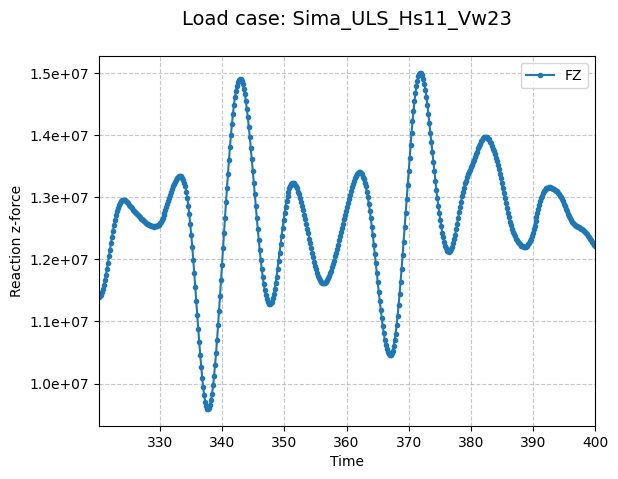

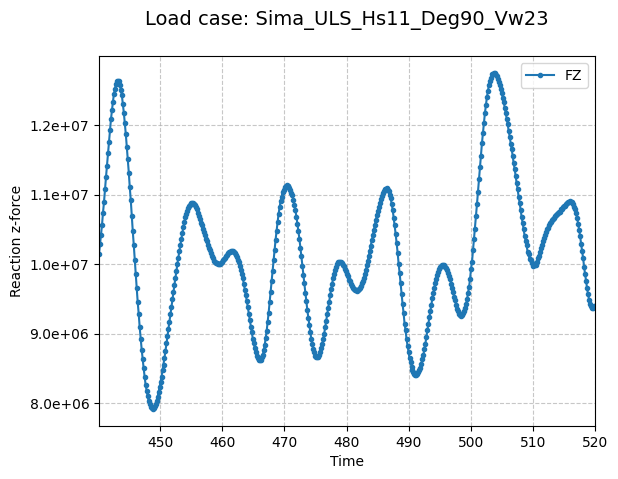

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import re
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

def format_time(value, _):
    return "{:.1e}".format(value)  # Format the time with two decimal places

#Loop over all load cases and plot graph of reaction force vs time for each load case
from itertools import islice
# Skip the first load case using islice to slice off the first item from input_data iterrows
for loadcase_folder_name, other in islice(input_data.iterrows(), 1, None):
    wasimSolverStart = other['StartWasimSolve']
    wasimSolverStop = other['StopWasimSolve']
#for loadcase_folder_name, _ in input_data.iterrows():
    # Reaction forces are reported in .csv file for dynamic analysis, but in sestra.lis for quasi-static analysis
    # args=f"{prefix_stru}_reactions_history1.csv" #from Sestra DREA card
    # result_path = os.path.join(workspacePath,workflow_client.results_directory, loadcase_folder_name, args)
    # print(result_path)
    result_folder = os.path.join(workspacePath,workflow_client.results_directory,loadcase_folder_name)
    #print(result_folder)
    os.chdir(result_folder)
    data= {}
    
    # Open and parse the file
    section = None
    with open("sestra.lis", "r") as file:
        for line in file:
            line = line.strip()
            # Identify sections based on keywords
            if "Reaction force sum for all result cases" in line:
                section = "Reaction Force Sum"
                data[section] = []
            elif "Sum of load sum and reaction force sum" in line:
                section = "Load-Reaction Sum"
                data[section] = []
            
            # Process lines containing numeric values
            elif re.match(r".*[\d]+.*", line) and section:
                data[section].append( line.split(";"))

    # Convert to Pandas DataFrame
  
    df = pd.DataFrame(data)
    data["Reaction Force Sum"][0]
    reaction_force_df = pd.DataFrame(data["Reaction Force Sum"], columns=["result case", "tx", "ty", "tz", "rx", "ry", "rz"])
    for key, df in reaction_force_df.items():
        reaction_force_df[key] = df.apply(pd.to_numeric, errors='coerce')

    maxLoadCase = max(reaction_force_df["result case"])
    # Extract data for plotting
    time = wasimSolverStart + reaction_force_df["result case"] * (wasimSolverStop - wasimSolverStart)/maxLoadCase
    fz = reaction_force_df["tz"]

    # Plot a 2D graph
    plt.plot(time, fz, marker='.', label='FZ')
    # Extract the "tx" column (which represents x values)
    x_column = reaction_force_df["result case"]
    
    # # Add labels and title
    plt.xlabel(f"Time", fontsize=10)
    plt.ylabel('Reaction z-force', fontsize=10)
    plt.xticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_time))
    plt.yticks(fontsize=10)
    plt.title(f'Load case: {loadcase_folder_name}\n ', fontsize=14)
    plt.legend(fontsize=10)  # Show legend with labels

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis limits
    plt.xlim(min(time), max(time))
  
    # Show the plot
    plt.savefig(os.path.join(workspacePath,workflow_client.results_directory, loadcase_folder_name,"reaction_forces_plot.png"))
    plt.show()

### Print maximum usage factor and criterion for worst stiffener on each platefield, over all load cases

In [9]:
import os
from pathlib import Path
import glob
import pandas as pd

from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

panels_and_cases = pd.DataFrame()
panel_names = set()
for loadcase_folder_name, _ in input_data.iterrows():
    result_folder = os.path.join(workspacePath,workflow_client.results_directory, loadcase_folder_name)
        
    os.chdir(result_folder)

    # loop over all buckling result files (csv)
    
    schema={
        "math score": int
    }
    
    #.csv file runname is based on name given in SesamCore_buckling_template.jnl on RUN BUCKLING-CHECK line
    for file in glob.glob('SesamCore_runname1_panel*.csv'):
        gen = pd.read_csv(file, sep=';', dtype=schema, chunksize=10000000)
        # Set threshold value (here >=1) for removing the first few result cases to omit initial extreme results
        # This should be changed to 
        panel = pd.concat((x.query("`Result case id` >= 1") for x in gen), ignore_index=True)
        panel['Plate field'] = Path(file).stem
        panel['LoadCase'] = loadcase_folder_name
        if not panel.empty:
            panels_and_cases = pd.concat([panels_and_cases,panel])
            panel_names.add(Path(file).stem)

#Show table of worst usage factors
df2 = pd.DataFrame(columns=['Stiffener name','Plate field', 'UfMax','UfMax criterion','LoadCase', 'Time'])
for panel_name in panel_names:
    df = panels_and_cases.query('`Plate field` == @panel_name')
    df.reset_index(inplace=True) 
    if not df.empty:
        df2.loc[len(df2.index)] = dict(df.iloc[df['UfMax'].idxmax()])
df2.sort_values(by='UfMax',ascending=False,inplace=True)
#pd.set_option('display.max_rows', None)  # Set max rows to None to display all rows
print(f"Maximum Uf for each panel, taken over all result cases.")
display(df2)


13:19:29 27/06/2025
Maximum Uf for each panel, taken over all result cases.


,Stiffener name,Plate field,UfMax,UfMax criterion,LoadCase,Time
1,Stiffener_Pl191_2_,SesamCore_runname1_panel_Pl191_4__to__Pl191_1_,0.671438,Equation 6.78,Sima_ULS_Hs11_Deg90_Vw23,478.6
0,Stiffener_Pl192_Pl193_4_,SesamCore_runname1_panel_Pl192_Pl193_4__to__Pl...,0.297028,Equation 8.1,Sima_ULS_Hs11_Vw23,340.0


### Plot usage factors for each plate field (all stiffeners) over time-history of worst load case 

In [10]:
import pandas as pd
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import glob
from ipywidgets import interactive, Text, Dropdown, Layout
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
current_date = now.strftime("%d/%m/%Y")
print(current_time, current_date)

# Number of stiffeners/lines/graphs with worst Uf to display
number_of_plate_fields_to_display =10

# Result threshold value, e g show the first 10 graphs with maximum usage factors > than threshold value!
threshold_for_uf = 0.2

filtered_df = df2[df2['UfMax'] >= threshold_for_uf]
highest_usage_factor =filtered_df.head(number_of_plate_fields_to_display)
plate_fields_with_highest_uf= highest_usage_factor.head(number_of_plate_fields_to_display)["Plate field"].to_list()
#pd.set_option('display.max_rows', None)  # Set max rows to None to display all rows
print("Table of worst UfMax in decreasing order. Number of lines/graphs set by user.")
display(highest_usage_factor)

def multiplot(PlateField, LoadCase):
    import matplotlib as mpl

    # Set the default font size for all labels
    mpl.rcParams.update({'font.size': 16})
    stiffenernames = data_frames[PlateField]['Stiffener name'].unique()
    category_colors = dict(zip(stiffenernames, cm.rainbow(np.linspace(0, 1, len(stiffenernames)))))

    ax= data_frames[PlateField].plot(kind='scatter', x='Time', y='UfMax',  c=data_frames[PlateField]['Stiffener name'].apply(lambda x: category_colors[x]), figsize=(20, 7))
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=category)
           for category, color in category_colors.items()]
    ax.legend(handles=handles, title='Stiffener name')
    ax.set_title('UfMax over time-history for worst load case. Includes all time steps.') # Also those time steps omitted in max table reporting.
    fig = ax.get_figure()
    fig.savefig("UfMaxplot.png")

# for loadcase_folder_name, _ in df_cases.iterrows():
for loadcase_folder_name in highest_usage_factor['LoadCase'].unique():
    result_folder = os.path.join(workspacePath,workflow_client.results_directory, loadcase_folder_name)
        
    os.chdir(result_folder)
    data_frames = {}
    for file in glob.glob('SesamCore_runname1_panel*.csv'):
        try:
            data_frames[Path(file).stem] = pd.read_csv(file, sep=';')[['Time', 'UfMax', 'Stiffener name']]
        except:
            print(file + " had issues with formatting\n")
    
    if not data_frames:
        print("No valid cases found")
    else:
        # Create a larger dropdown widget for PlateField selection
        platefield_dropdown = widgets.Dropdown(
        #options=list(data_frames.keys()),  # PlateField options
        options=plate_fields_with_highest_uf,  # PlateField options
        description='PlateField:',
        layout=widgets.Layout(width='600px')  # Increase width
    )

    # Create an interactive plot with a larger PlateField selection box
    interactive_plot = interactive(multiplot, PlateField=platefield_dropdown, LoadCase=loadcase_folder_name)
    print("Table of worst UfMax in decreasing order. Number of lines/graphs set by user.")
    display(interactive_plot)


13:19:29 27/06/2025
Table of worst UfMax in decreasing order. Number of lines/graphs set by user.


,Stiffener name,Plate field,UfMax,UfMax criterion,LoadCase,Time
1,Stiffener_Pl191_2_,SesamCore_runname1_panel_Pl191_4__to__Pl191_1_,0.671438,Equation 6.78,Sima_ULS_Hs11_Deg90_Vw23,478.6
0,Stiffener_Pl192_Pl193_4_,SesamCore_runname1_panel_Pl192_Pl193_4__to__Pl...,0.297028,Equation 8.1,Sima_ULS_Hs11_Vw23,340.0


Table of worst UfMax in decreasing order. Number of lines/graphs set by user.


interactive(children=(Dropdown(description='PlateField:', layout=Layout(width='600px'), options=('SesamCore_ru…

Table of worst UfMax in decreasing order. Number of lines/graphs set by user.


interactive(children=(Dropdown(description='PlateField:', layout=Layout(width='600px'), options=('SesamCore_ru…